In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def compute_mse(y,tx,w):
    e = y-tx.dot(w)
    return 1./(2.*y.shape[0])*e.dot(e)

In [3]:
def compute_rmse(y,tx,w):
    return np.sqrt(2*compute_mse(y,tx,w))

In [4]:
def least_squares(y, tx, fct='none'):
    """calculate the least squares solution."""
    wstar = np.linalg.solve(tx.T.dot(tx),(tx.T).dot(y))
    if fct=='mse':
        mse = compute_mse(y,tx,wstar)
        return mse, wstar
    elif fct=='rmse':
        rmse = compute_rmse(y,tx,wstar)
        return rmse, wstar
    else: #'none'
        return wstar

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [5]:
from helpers import *
from grid_search import generate_w, grid_search, get_best_parameters
from costs import compute_loss

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)

    grid_w0, grid_w1 = generate_w(num_intervals=300)
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    gswstar = np.array([w0_star, w1_star])
    
    lswstar = least_squares(y,tx,'none')
    return lswstar-gswstar

Test it here

In [6]:
test_your_least_squares()

array([-0.28467332, -0.06543807])

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [7]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [8]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    return np.array([x**p for p in range(degree+1)]).T

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [9]:
from costs import compute_loss
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        phix = build_poly(x, degree)
        rmse, weights = least_squares(y, phix,'rmse')

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737495
Processing 3th experiment, degree=7, rmse=0.2496587036090732
Processing 4th experiment, degree=12, rmse=0.2408825776919281


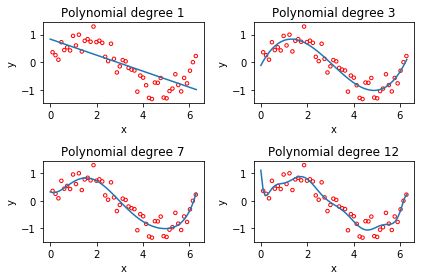

In [10]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [11]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    
    # split data with the given ratio
    data_size = len(y)
    training_size = int(np.round(data_size*ratio))

    shuffle_indices = np.random.permutation(np.arange(data_size))
    
    shuffled_y = y[shuffle_indices]
    shuffled_tx = x[shuffle_indices]
    y_train = shuffled_y[0:training_size]
    x_train = shuffled_tx[0:training_size]
    y_test = shuffled_y[training_size:]
    x_test = shuffled_tx[training_size:]
        
    return y_train, x_train, y_test, x_test


Yes, the order of the samples is important when doing the split because the list of data can be ordered, and we want data as diversified as possible. So we have to shuffle the data before choosing the entries we want to use as training set or testing set. 

Then, test your `split_data` function below.

In [12]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""

    # split the data, and return train and test data
    y_train, x_train, y_test, x_test = split_data(x,y,ratio,seed)

    # form train and test data with polynomial basis function
    tx_train = build_poly(x_train, degree)
    tx_test = build_poly(x_test, degree)

    # calculate weight through least square
    weight = least_squares(y_train, tx_train)

    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively
    rmse_tr = compute_rmse(y_train, tx_train, weight)
    rmse_te = compute_rmse(y_test, tx_test, weight)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [13]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.243, Testing RMSE=0.255
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.379
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.259
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=4.637


- For degree 3, the RMSE of the training set decreases when the proportion of the data given to the training set is decreased, while in this same case, the RMSE of the testing set increases. This makes sense since the less data the better it can be fitted with a low-order polynomial, but the less accurate it is on a larger set of data (since it is less representative of the whole data set). 
- The behaviour is the same for any tested polynomial degree, which makes sense, even if it is even more drastic when the degree is high. 
- The better split is the one for which the RMSE in the testing set is the lower, that is training=90%, testing=10%. Indeed, the more data we use to train, the better is the fit on any additional data, since we do not have so much data points (only 50). The algorithm learns better. 
- The test RMSE is very high for degree=12 since it overfits the training set. **(Numerical accuracy??)**
- With more data (for example 5000 instead of 50), we would need less samples in the training set to have a better RMSE. A good split would then be 50%-50%. 

# 3 Ridge Regression
Please fill in the function below.

In [14]:
def compute_ridge_mse(y,tx,w,lambda_):
    mse = compute_mse(y,tx,w)
    return mse + lambda_*np.linalg.norm(w)**2

In [15]:
def compute_ridge_rmse(y,tx,w,lambda_):
    return np.sqrt(2*compute_ridge_mse(y,tx,w,lambda_))

In [16]:
from numpy import matlib

def ridge_regression(y, tx, lambda_, fct='none'):
    """implement ridge regression."""
    wstar = np.linalg.solve(tx.T.dot(tx)+2*y.shape[0]*lambda_*np.matlib.identity(tx.shape[1]),(tx.T).dot(y))
    if fct=='mse':
        ridge = compute_ridge_mse(y,tx,wstar,lambda_)
        return ridge, wstar
    elif fct=='rmse':
        ridge = compute_ridge_rmse(y,tx,wstar,lambda_)
        return ridge, wstar
    else: #'none'
        return wstar

In [17]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    train_y, train_x, test_y, test_x = split_data(x, y, ratio, seed)
    train_tx = build_poly(train_x,degree)
    test_tx = build_poly(test_x,degree)
    
    rmse_tr = np.zeros(len(lambdas))
    rmse_te = np.zeros(len(lambdas))
    for ind, lambda_ in enumerate(lambdas):
        wstar = ridge_regression(train_y, train_tx, lambda_)
        rmse_tr[ind] = compute_rmse(train_y, train_tx, wstar)
        rmse_te[ind] = compute_rmse(test_y, test_tx, wstar)
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

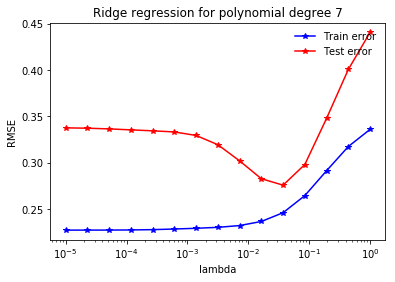

In [18]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)